<a href="https://colab.research.google.com/github/Gio1709/paddy_100m_new/blob/master/Identifikasi_Lahan_Pertanian_100m_dan_Perbandingannya_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IDENTIFIKASI VEGETASI OTOMATIS DENGAN GAMBAR GOOGLE EARTH MENGGUNAKAN CONVOLUTIONAL NEURAL NETWORK**

# Preferensi

Penelitian Sebelumnya :
**Metode Convolutional Neural Network pada Gambar Google Earth Hutan Bambu di Jepang dengan .** 

*Shuntaro Watanabe, Kazuaki Sumi, Takeshi Ise*

link sebagai berikut : https://doi.org/10.1101/351643

**Note**

Penelitian ini mengambil konsep dari peneliti asal Jepang yang mengidentifikasikan vegatasi akurasi tinggi lahan hutan bamboo di beberapa wilayah Jepang, dengan klasisfikasi CNN, dan dilakukan dengan metode chopped-image.

Sedangkan pada penelitian ini memiliki konsep yang serupa dengan penelitian sebelumnya, akan tetapi mengambil sampel yang dilakukan lahan persawahan di Kabupaten Banyumas. 

Peneliti : Fendy Prayogi

Repositori tersedia pada : https://github.com/Gio1709/paddy


# Mengimpor/Mengambil Fungsi Library

In [1]:
!pip install slidingwindow
import slidingwindow as sw
import numpy as np
import os
import keras.backend as K
import keras
import pandas as pd
from keras.models import Sequential
from keras import layers
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from skimage.transform import resize
from sklearn.utils.class_weight import compute_class_weight

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels



Using TensorFlow backend.


# Mengambil Dataset dari Github

In [0]:
# Mengambil dataset dari github

#!apt-get install subversion > /dev/null
#!svn export https://github.com/Gio1709/paddy/trunk/data > /dev/null 

#!apt-get install subversion > /dev/null
#!svn export https://github.com/Gio1709/paddy_100/trunk/data > /dev/null 

#!apt-get install subversion > /dev/null
#!svn export https://github.com/Gio1709/paddy_300/trunk/data > /dev/null 

#!apt-get install subversion > /dev/null
#!svn export https://github.com/Gio1709/paddy-coba/trunk/data/ > /dev/null 

!apt-get install subversion > /dev/null
!svn export https://github.com/Gio1709/paddy_100m_new/trunk/data/ > /dev/null 

#!apt-get install subversion > /dev/null
#!svn export https://github.com/Gio1709/paddy_300m_new/trunk/data/ > /dev/null 

#!wget https://raw.githubusercontent.com/Gio1709/paddy/master/paddy.zip paddy.zip
#!unzip -P paddy paddy.zip


**Persiapan :**

*Program ini dibuat untuk mengidentifikasi lahan sawah dan luas di Kabupaten Banyumas*

File tersimpan dalam folder :
1. */chopped*
2. */train*
3. */test* 

# Mengimpor Datasheet

In [3]:
#Perintah untuk melihat list bagian dari file yang sudah diunduh dari Github

!ls data/paddy/train
!ls data/paddy/train/Jawa
!ls data/paddy/train/Kalimantan
!ls data/paddy/train/Sumatra
#gambar dengan nama awalan dengan "b" adalah gambar yang terdapat padi"
#gambar dengan nama awalan dengan "o" adalah gambar yang tidak terdapat padi"

Jawa  Kalimantan  Sumatra
b51.jpg  b57.jpg  b63.jpg  b69.jpg  b75.jpg  o56.jpg  o62.jpg  o68.jpg	o74.jpg
b52.jpg  b58.jpg  b64.jpg  b70.jpg  o51.jpg  o57.jpg  o63.jpg  o69.jpg	o75.jpg
b53.jpg  b59.jpg  b65.jpg  b71.jpg  o52.jpg  o58.jpg  o64.jpg  o70.jpg
b54.jpg  b60.jpg  b66.jpg  b72.jpg  o53.jpg  o59.jpg  o65.jpg  o71.jpg
b55.jpg  b61.jpg  b67.jpg  b73.jpg  o54.jpg  o60.jpg  o66.jpg  o72.jpg
b56.jpg  b62.jpg  b68.jpg  b74.jpg  o55.jpg  o61.jpg  o67.jpg  o73.jpg
b100.jpg  b82.jpg  b89.jpg  b96.jpg   o78.jpg  o85.jpg	o92.jpg  o99.jpg
b76.jpg   b83.jpg  b90.jpg  b97.jpg   o79.jpg  o86.jpg	o93.jpg
b77.jpg   b84.jpg  b91.jpg  b98.jpg   o80.jpg  o87.jpg	o94.jpg
b78.jpg   b85.jpg  b92.jpg  b99.jpg   o81.jpg  o88.jpg	o95.jpg
b79.jpg   b86.jpg  b93.jpg  o100.jpg  o82.jpg  o89.jpg	o96.jpg
b80.jpg   b87.jpg  b94.jpg  o76.jpg   o83.jpg  o90.jpg	o97.jpg
b81.jpg   b88.jpg  b95.jpg  o77.jpg   o84.jpg  o91.jpg	o98.jpg
b101.jpg  b108.jpg  b115.jpg  b122.jpg	o104.jpg  o111.jpg  o118.jpg  o125.jpg
b102

#Menampilkan Gambar Pelatihan

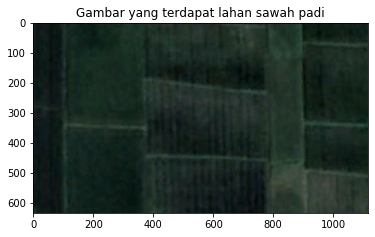

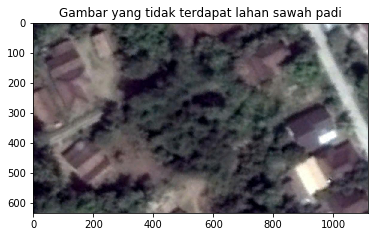

In [4]:
#Gambar yang terdapat lahan sawah padi
plt.title("Gambar yang terdapat lahan sawah padi")
plt.imshow(imread("data/paddy/train/Jawa/b58.jpg"))
plt.show()

#Gambar yang terdapat tidak lahan sawah padi
plt.title("Gambar yang tidak terdapat lahan sawah padi")
plt.imshow(imread("data/paddy/train/Sumatra/o125.jpg"))
plt.show()


# Membuat "patches" dari setiap gambar menggunakan metode sliding window

**Apa itu *Sliding Window* ?**

*Sliding window* adalah window yang bergeser untuk memprediksi dan mencari area objek yang benar. Suatu proses deteksi objek memerlukan teknik lokalisasi 
untuk menemukan area objek. 



In [5]:
def save_to_folder(img_path,directory,size=56,overlap=0.4):
    #Membaca gambar path penyimpanan window ke direktori/file yang spesifik
    img = imread(img_path)
    basename = os.path.basename(img_path)
    fname = os.path.splitext(basename)[0]
    windows = sw.generate(img, sw.DimOrder.HeightWidthChannel, size, overlap)
    for i,window in enumerate(windows):
        ii = str("{0:05d}".format(i))
        _fname = fname + "_" + ii + ".jpg"
        _img = img[window.indices()]
        if _img.shape !=(size,size,3):
            continue
        img_target_path = os.path.join(directory,_fname)
        
        imsave(img_target_path,_img)

files = os.listdir("data/paddy/train/Jawa")
files = [x for x in files if x.endswith(".jpg")]

#Menyimpan gambar yang telah dicacah pada folder chopped
for file in files:
    save_directory = "data/paddy/chopped/Jawa"
    file = os.path.join("data/paddy/train/Jawa",file)
    save_to_folder(file,save_directory)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: data/paddy/chopped/Jawa/o56_00009.jpg is a low contrast image
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: data/paddy/chopped/Jawa/o56_00010.jpg is a low contrast image
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: data/paddy/chopped/Jawa/o56_00011.jpg is a low contrast image
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: data/paddy/chopped/Jawa/o56_00025.jpg is a low contrast image
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: data/paddy/chopped/Jawa/o56_00026.jpg is a low contrast image
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: data/paddy/choppe

In [6]:
files = os.listdir("data/paddy/train/Kalimantan")
files = [x for x in files if x.endswith(".jpg")]

#Menyimpan gambar yang telah dicacah pada folder chopped
for file in files:
    save_directory = "data/paddy/chopped/Kalimantan"
    file = os.path.join("data/paddy/train/Kalimantan",file)
    save_to_folder(file,save_directory)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: data/paddy/chopped/Kalimantan/b92_00001.jpg is a low contrast image
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: data/paddy/chopped/Kalimantan/b92_00002.jpg is a low contrast image
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: data/paddy/chopped/Kalimantan/b92_00003.jpg is a low contrast image
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: data/paddy/chopped/Kalimantan/b92_00004.jpg is a low contrast image
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: data/paddy/chopped/Kalimantan/b92_00005.jpg is a low contrast image
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: 

In [7]:
files = os.listdir("data/paddy/train/Sumatra")
files = [x for x in files if x.endswith(".jpg")]

#Menyimpan gambar yang telah dicacah pada folder chopped
for file in files:
    save_directory = "data/paddy/chopped/Sumatra"
    file = os.path.join("data/paddy/train/Sumatra",file)
    save_to_folder(file,save_directory)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: data/paddy/chopped/Sumatra/o115_00006.jpg is a low contrast image
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: data/paddy/chopped/Sumatra/o115_00023.jpg is a low contrast image
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: data/paddy/chopped/Sumatra/o115_00024.jpg is a low contrast image
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: data/paddy/chopped/Sumatra/o115_00564.jpg is a low contrast image
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: data/paddy/chopped/Sumatra/b104_00000.jpg is a low contrast image
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarnin

# Dataset Pelatihan dari 3 Pulau Berbeda
Terdapat 3 dataset yang digunakan dalam Model Performa Klasifikasi akurasi, Recall Rate dan Presisi. Data pelatihan yang telah dichop sehingga menghasilkan gambar baru, lalu kita klasifikasikan hasilnya dengan empat kategori berupa :  *true positive* (TP), *false positive* (FP), *false negative* (FN), dan *true negative* (TN). 
Dengan ketentuan prediksi benar atau salah dan gambar sawah atau bukan sawah. Pada Gambar Sawah dilabeli dengan nama huruf "b" dan ada gambar bukan sawah dilabeli dengan nama huruf "o".

**Pulau Jawa**

In [8]:
#Mengembalikan daftar gambar yang telah diacak pada direktori
#Data yang dilakukan pada model evaluasi

#Dataset Pulau Jawa
files = os.listdir("data/paddy/chopped/Jawa")
files = [x for x in files if x.endswith(".jpg")]

#Memuat dataset Pelatihan
x = []
y = []

for file in files:
    if file.startswith("b"):
        label = 1
    else:
        label = 0
    
    img_path = os.path.join("data/paddy/chopped/Jawa",file)
    #img_path = os.path.join("data/paddy/chopped/Kalimantan",file)
    #img_path = os.path.join("data/paddy/chopped/Sumatra",file)
    img = load_img(img_path)
    img = img_to_array(img)/255
    x.append(img)
    y.append(label)

x = np.array(x)
X = x.reshape(x.shape[0], -1)
Y = np.array(y)
print("Dataset Pula Jawa")
print("Bentuk array dari dataset train (pelatihan) adalah :", (X.shape,Y.shape))

files= pd.Index(files)
print("Tampilan list gambar yang telah dichop :\n",files.value_counts())

Dataset Pula Jawa
Bentuk array dari dataset train (pelatihan) adalah : ((29700, 9408), (29700,))
Tampilan list gambar yang telah dichop :
 o70_00325.jpg    1
o57_00398.jpg    1
b69_00341.jpg    1
o64_00572.jpg    1
b69_00513.jpg    1
                ..
o59_00139.jpg    1
o56_00026.jpg    1
b52_00124.jpg    1
o61_00327.jpg    1
o60_00079.jpg    1
Length: 29700, dtype: int64


**Pulau Kalimantan**

In [9]:
#Mengembalikan daftar gambar yang telah diacak pada direktori
#Data yang dilakukan pada model evaluasi

#Dataset Pulau Kalimantan
files = os.listdir("data/paddy/chopped/Kalimantan")
files = [x for x in files if x.endswith(".jpg")]

#Memuat dataset Pelatihan
x1 = []
y1 = []

for file in files:
    if file.startswith("b"):
        label1 = 1
    else:
        label1 = 0
    
    img_path1 = os.path.join("data/paddy/chopped/Kalimantan",file)
    #img_path1 = os.path.join("data/paddy/chopped/Kalimantan",file)
    #img_path1 = os.path.join("data/paddy/chopped/Sumatra",file)
    img1 = load_img(img_path1)
    img1 = img_to_array(img1)/255
    x1.append(img1)
    y1.append(label1)

x1 = np.array(x1)
X1 = x1.reshape(x1.shape[0], -1)
Y1 = np.array(y1)
print("Dataset Pula Kalimantan")
print("Bentuk array dari dataset train (pelatihan) adalah :", (X1.shape,Y1.shape))

files= pd.Index(files)
print("Tampilan list gambar yang telah dichop :\n",files.value_counts())

Dataset Pula Kalimantan
Bentuk array dari dataset train (pelatihan) adalah : ((29700, 9408), (29700,))
Tampilan list gambar yang telah dichop :
 o84_00167.jpg    1
o95_00370.jpg    1
b91_00554.jpg    1
b77_00349.jpg    1
o88_00210.jpg    1
                ..
o99_00121.jpg    1
b88_00310.jpg    1
b83_00032.jpg    1
o87_00451.jpg    1
o79_00014.jpg    1
Length: 29700, dtype: int64


**Pulau Sumatra**

In [10]:
#Mengembalikan daftar gambar yang telah diacak pada direktori
#Data yang dilakukan pada model evaluasi

#Dataset Pulau Jawa
#files = os.listdir("data/paddy/chopped/Jawa")
#files = [x for x in files if x.endswith(".jpg")]

#Dataset Pulau Kalimantan
#files = os.listdir("data/paddy/chopped/Kalimantan")
#files = [x for x in files if x.endswith(".jpg")]

#Dataset Pulau Sumatra
files = os.listdir("data/paddy/chopped/Sumatra")
files = [x for x in files if x.endswith(".jpg")]

#Memuat dataset Pelatihan
x2 = []
y2 = []

for file in files:
    if file.startswith("b"):
        label2 = 1
    else:
        label2 = 0
    
    img_path2 = os.path.join("data/paddy/chopped/Sumatra",file)
    img2 = load_img(img_path2)
    img2 = img_to_array(img2)/255
    x2.append(img2)
    y2.append(label2)

x2 = np.array(x2)
X2 = x2.reshape(x2.shape[0], -1)
Y2 = np.array(y2)
print("Dataset Pula Kalimantan")
print("Bentuk array dari dataset train (pelatihan) adalah :", (X2.shape,Y2.shape))

files= pd.Index(files)
print("Tampilan list gambar yang telah dichop :\n",files.value_counts())

Dataset Pula Kalimantan
Bentuk array dari dataset train (pelatihan) adalah : ((29700, 9408), (29700,))
Tampilan list gambar yang telah dichop :
 o110_00558.jpg    1
o124_00546.jpg    1
b116_00521.jpg    1
b113_00182.jpg    1
o105_00089.jpg    1
                 ..
o108_00450.jpg    1
o103_00576.jpg    1
b123_00406.jpg    1
o106_00289.jpg    1
o120_00346.jpg    1
Length: 29700, dtype: int64


In [0]:
# Membagi X dan Y kedalam data pelatihan dan testing
from sklearn.model_selection import train_test_split
X_train, test_x, y_train, test_y = train_test_split(X, Y, random_state=0)
X_train1, test_x1, y_train1, test_y1 = train_test_split(X1, Y1, random_state=0)
X_train2, test_x2, y_train2, test_y2 = train_test_split(X2, Y2, random_state=0)

In [12]:
print(X_train, y_train)
print(X_train.shape, y_train.shape)
print(test_x, test_y)
print(test_x.shape, test_y.shape)
print(X_train1, y_train1)
print(X_train1.shape, y_train1.shape)
print(test_x1, test_y1)
print(test_x1.shape, test_y1.shape)
print(X_train2, y_train2)
print(X_train2.shape, y_train2.shape)
print(test_x2, test_y2)
print(test_x2.shape, test_y2.shape)

[[0.07843138 0.16078432 0.14117648 ... 0.0627451  0.1254902  0.12156863]
 [0.08627451 0.20784314 0.14901961 ... 0.09803922 0.18431373 0.13333334]
 [0.5686275  0.5058824  0.5176471  ... 0.74509805 0.7294118  0.73333335]
 ...
 [0.5411765  0.4745098  0.5058824  ... 0.4745098  0.39607844 0.43137255]
 [0.52156866 0.5137255  0.45490196 ... 0.35686275 0.42352942 0.3529412 ]
 [0.0627451  0.14117648 0.10588235 ... 0.0627451  0.13725491 0.12156863]] [1 1 0 ... 0 0 1]
(22275, 9408) (22275,)
[[0.50980395 0.49019608 0.5058824  ... 0.12941177 0.09019608 0.08627451]
 [0.3529412  0.3254902  0.3529412  ... 0.2        0.16470589 0.16862746]
 [0.7254902  0.654902   0.6392157  ... 0.39607844 0.3647059  0.35686275]
 ...
 [0.18039216 0.16862746 0.23529412 ... 0.14901961 0.14901961 0.11764706]
 [0.49803922 0.45882353 0.4627451  ... 0.6117647  0.5686275  0.58431375]
 [0.32941177 0.27058825 0.29803923 ... 0.05882353 0.10196079 0.11764706]] [0 0 0 ... 0 0 0]
(7425, 9408) (7425,)
[[0.43529412 0.40392157 0.321568

In [13]:
# Pelatihan model logistic regression pada set training
from sklearn.linear_model import LogisticRegression

# instantiate model
logreg = LogisticRegression()

# fit model
logreg.fit(X_train, y_train)
logreg.fit(X_train1, y_train1)
logreg.fit(X_train2, y_train2)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
# Membuat class predictions pada testing set
y_pred_class = logreg.predict(test_x)
y_pred_class1 = logreg.predict(test_x1)
y_pred_class2 = logreg.predict(test_x2)

In [15]:
# Mengkalkulasi accuracy
from sklearn import metrics
print("Akurasi pada data Pulau Jawa:",metrics.accuracy_score(test_y, y_pred_class))
print("Akurasi pada data Pulau Kalimantan:",metrics.accuracy_score(test_y1, y_pred_class1))
print("Akurasi pada data Pulau Sumatra:",metrics.accuracy_score(test_y2, y_pred_class2))

Akurasi pada data Pulau Jawa: 0.8739393939393939
Akurasi pada data Pulau Kalimantan: 0.7352188552188552
Akurasi pada data Pulau Sumatra: 0.804983164983165


In [16]:
# Mengetahui class berdasarkan gambar sawah dan bukan sawah 
# Apabila 1 menandakan gambar sawah dan 0 bukan sawah 

test_Y = pd.Index(test_y)
print("Class dan jumlah data Pulau Jawa:\n Class Jumlah \n",test_Y.value_counts())
print("\n")
test_Y1 = pd.Index(test_y1)
print("Class dan jumlah data Pulau Kalimantan:\n Class Jumlah \n",test_Y1.value_counts())
print("\n")
test_Y2 = pd.Index(test_y2)
print("Class dan jumlah data Pulau Kalimantan:\n Class Jumlah \n",test_Y2.value_counts())

Class dan jumlah data Pulau Jawa:
 Class Jumlah 
 1    3794
0    3631
dtype: int64


Class dan jumlah data Pulau Kalimantan:
 Class Jumlah 
 0    3716
1    3709
dtype: int64


Class dan jumlah data Pulau Kalimantan:
 Class Jumlah 
 0    3721
1    3704
dtype: int64


In [0]:
# calculate the percentage of ones
# because y_test only contains ones and zeros, we can simply calculate the mean = percentage of ones
#print(test_y.mean())
#print(test_y1.mean())
#print(test_y2.mean())

# calculate the percentage of zeros
#print(1 - test_y.mean())
#print(1 - test_y1.mean())
#print(1 - test_y2.mean())

# calculate null accuracy in a single line of code
# only for binary classification problems coded as 0/1
#print(max(test_y.mean(), 1 - test_y.mean()))
#print(max(test_y1.mean(), 1 - test_y1.mean()))
#print(max(test_y2.mean(), 1 - test_y2.mean()))

# calculate null accuracy (for multi-class classification problems)
#print(test_Y.value_counts().head(1) / len(test_y))
#print(test_Y1.value_counts().head(1) / len(test_y1))
#print(test_Y2.value_counts().head(1) / len(test_y2))

In [18]:
# Menampilkan 25 data pertama/awal true atau pun prediksi 
print("Dataset Pulau Jawa:")
print('True:', test_Y.values[0:25])
print('False:', y_pred_class[0:25])
print("\n")
print("Dataset Pulau Kalimantan:")
print('True:', test_Y1.values[0:25])
print('False:', y_pred_class1[0:25])
print("\n")
print("Dataset Pulau Sumatra:")
print('True:', test_Y2.values[0:25])
print('False:', y_pred_class2[0:25])

Dataset Pulau Jawa:
True: [0 0 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1]
False: [0 0 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1]


Dataset Pulau Kalimantan:
True: [0 1 0 0 1 0 0 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 1 0]
False: [1 1 1 1 0 0 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0]


Dataset Pulau Sumatra:
True: [0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0]
False: [0 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 1 0 0]


In [19]:
# IMPORTANT: first argument is true values, second argument is predicted values
# this produces a 2x2 numpy array (matrix)
# save confusion matrix and slice into four pieces
confusion = metrics.confusion_matrix(test_y, y_pred_class)
print("Matriks hasil clasification Pulau Jawa:\n",confusion)
#[row, column]
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

# IMPORTANT: first argument is true values, second argument is predicted values
# this produces a 2x2 numpy array (matrix)
# save confusion matrix and slice into four pieces
confusion1 = metrics.confusion_matrix(test_y1, y_pred_class1)
print("Matriks hasil clasification Pulau Kalimantan:\n",confusion1)
#[row, column]
TP1 = confusion1[1, 1]
TN1 = confusion1[0, 0]
FP1 = confusion1[0, 1]
FN1 = confusion1[1, 0]

# IMPORTANT: first argument is true values, second argument is predicted values
# this produces a 2x2 numpy array (matrix)
# save confusion matrix and slice into four pieces
confusion2 = metrics.confusion_matrix(test_y2, y_pred_class2)
print("Matriks hasil clasification Pulau Sumatra:\n",confusion2)
#[row, column]
TP2 = confusion2[1, 1]
TN2 = confusion2[0, 0]
FP2 = confusion2[0, 1]
FN2 = confusion2[1, 0]

Matriks hasil clasification Pulau Jawa:
 [[2719  912]
 [  24 3770]]
Matriks hasil clasification Pulau Kalimantan:
 [[1969 1747]
 [ 219 3490]]
Matriks hasil clasification Pulau Sumatra:
 [[2680 1041]
 [ 407 3297]]


Classification accuracy Pulau Jawa: 0.8739393939393939
Classification accuracy Pulau Kalimantan: 0.7352188552188552
Classification accuracy Pulau Sumatra: 0.804983164983165


Text(0, 0.5, 'Accuracy')

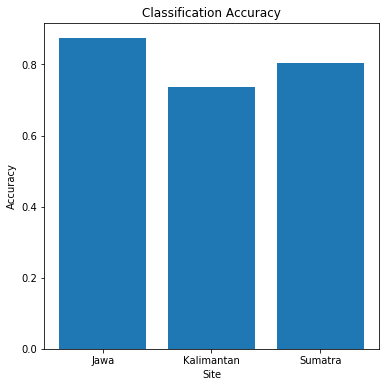

In [20]:
# Classification accuracy dari ketiga pulau 
#print((TP + TN) / float(TP + TN + FP + FN))
print("Classification accuracy Pulau Jawa:",metrics.accuracy_score(test_y, y_pred_class))

#print((TP1 + TN1) / float(TP1 + TN1 + FP1 + FN1))
print("Classification accuracy Pulau Kalimantan:",metrics.accuracy_score(test_y1, y_pred_class1))

#print((TP2 + TN2) / float(TP2 + TN2 + FP2 + FN2))
print("Classification accuracy Pulau Sumatra:",metrics.accuracy_score(test_y2, y_pred_class2))

import matplotlib.pyplot as plt

data = {'Jawa': metrics.accuracy_score(test_y, y_pred_class), 'Kalimantan': metrics.accuracy_score(test_y1, y_pred_class1), 'Sumatra': metrics.accuracy_score(test_y2, y_pred_class2)}
names = list(data.keys())
values = list(data.values())

fig, axs = plt.subplots(1, 1, figsize=(6, 6), sharey=True)
axs.bar(names, values)

plt.title('Classification Accuracy')
plt.xlabel('Site')
plt.ylabel('Accuracy')

In [21]:
classification_error = (FP + FN) / float(TP + TN + FP + FN)
#print(classification_error)
#print(1 - metrics.accuracy_score(test_y, y_pred_class))
print("Classification error Pulau Jawa:",1 - metrics.accuracy_score(test_y, y_pred_class))

classification_error1 = (FP1 + FN1) / float(TP1 + TN1 + FP1 + FN1)
#print(classification_error1)
print("Classification error Pulau Kalimantan:",1 - metrics.accuracy_score(test_y1, y_pred_class1))

classification_error = (FP2 + FN2) / float(TP2 + TN2 + FP2 + FN2)
#print(classification_error)
print("Classification error Pulau Sumatra:",1 - metrics.accuracy_score(test_y2, y_pred_class2))

Classification error Pulau Jawa: 0.1260606060606061
Classification error Pulau Kalimantan: 0.2647811447811448
Classification error Pulau Sumatra: 0.19501683501683498


Recall Rate Sawah Pulau Jawa: 0.9936742224565103
Recall Rate Sawah Pulau Kalimantan: 0.9409544351577245
Recall Rate Sawah Pulau Sumatra: 0.8901187904967602


Text(0, 0.5, 'Recall Rate')

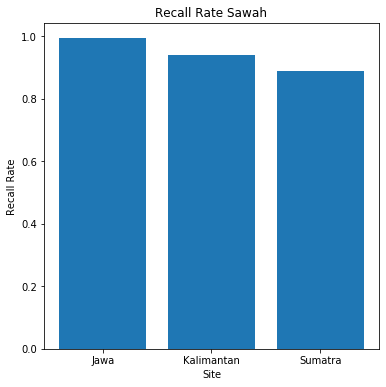

In [22]:
recall_rate_sawah = TP / float(FN + TP)

print("Recall Rate Sawah Pulau Jawa:",recall_rate_sawah)
#print(metrics.recall_score(test_y, y_pred_class))

recall_rate_sawah1 = TP1 / float(FN1 + TP1)

print("Recall Rate Sawah Pulau Kalimantan:",recall_rate_sawah1)
#print(metrics.recall_score(test_y1, y_pred_class1))

recall_rate_sawah2 = TP2 / float(FN2 + TP2)

print("Recall Rate Sawah Pulau Sumatra:",recall_rate_sawah2)
#print(metrics.recall_score(test_y2, y_pred_class2))

import matplotlib.pyplot as plt
import decimal

data = {'Jawa': recall_rate_sawah, 'Kalimantan': recall_rate_sawah1, 'Sumatra': recall_rate_sawah2}
names = list(data.keys())
values = list(data.values())

fig, ax = plt.subplots(1, 1, figsize=(6, 6), sharey=True)
ax.bar(names, values)

plt.title('Recall Rate Sawah')
plt.xlabel('Site')
plt.ylabel('Recall Rate')

Recall Rate Bukan Sawah Pulau Jawa: 0.7488295235472322
Recall Rate Bukan Sawah Pulau Kalimantan: 0.5298708288482239
Recall Rate Bukan Sawah Pulau Sumatra: 0.7202364955657081


Text(0, 0.5, 'Recall Rate')

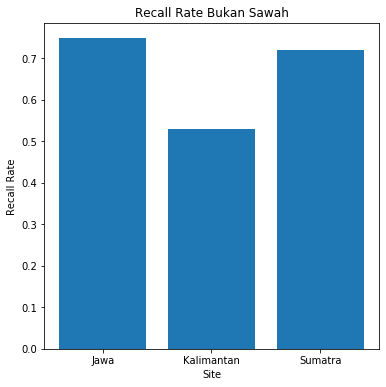

In [23]:
recall_rate_bukan_sawah = TN / (TN + FP)
print("Recall Rate Bukan Sawah Pulau Jawa:",recall_rate_bukan_sawah)

recall_rate_bukan_sawah1 = TN1 / (TN1 + FP1)
print("Recall Rate Bukan Sawah Pulau Kalimantan:",recall_rate_bukan_sawah1)

recall_rate_bukan_sawah2 = TN2 / (TN2 + FP2)
print("Recall Rate Bukan Sawah Pulau Sumatra:",recall_rate_bukan_sawah2)

import matplotlib.pyplot as plt
import decimal

data = {'Jawa': recall_rate_bukan_sawah, 'Kalimantan': recall_rate_bukan_sawah1, 'Sumatra': recall_rate_bukan_sawah2}
names = list(data.keys())
values = list(data.values())

fig, ax = plt.subplots(1, 1, figsize=(6, 6), sharey=True)
ax.bar(names, values)

plt.title('Recall Rate Bukan Sawah')
plt.xlabel('Site')
plt.ylabel('Recall Rate')

In [24]:
false_positive_rate = FP / float(TN + FP)
#print(false_positive_rate)
print("false positive rate Pulau Jawa:",1 - recall_rate_bukan_sawah)

false_positive_rate1 = FP1 / float(TN1 + FP1)
#print(false_positive_rate1)
print("false positive rate Pulau Kalimantan:",1 - recall_rate_bukan_sawah1)

false_positive_rate2 = FP2 / float(TN2 + FP2)
#print(false_positive_rate2)
print("false positive rate Pulau Sumatra:",1 - recall_rate_bukan_sawah2)

false positive rate Pulau Jawa: 0.2511704764527678
false positive rate Pulau Kalimantan: 0.4701291711517761
false positive rate Pulau Sumatra: 0.2797635044342919


Precision Sawah Pulau Jawa: 0.8052114480991029
Precision Sawah Pulau Kalimantan: 0.6664120679778499
Precision Sawah Pulau Sumatra: 0.760027662517289


Text(0, 0.5, 'Recall Rate')

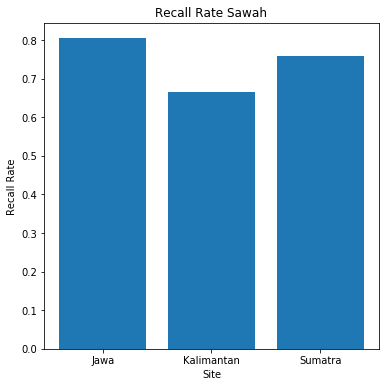

In [25]:
precision_sawah = TP / float(TP + FP)
print("Precision Sawah Pulau Jawa:",precision_sawah)

precision_sawah1 = TP1 / float(TP1 + FP1)
print("Precision Sawah Pulau Kalimantan:",precision_sawah1)

precision_sawah2 = TP2 / float(TP2 + FP2)
print("Precision Sawah Pulau Sumatra:",precision_sawah2)

import matplotlib.pyplot as plt
import decimal

data = {'Jawa': precision_sawah, 'Kalimantan': precision_sawah1, 'Sumatra': precision_sawah2}
names = list(data.keys())
values = list(data.values())

fig, ax = plt.subplots(1, 1, figsize=(6, 6), sharey=True)
ax.bar(names, values)

plt.title('Recall Rate Sawah')
plt.xlabel('Site')
plt.ylabel('Recall Rate')

Precision Bukan Sawah Pulau Jawa: 0.5807347287483982
Precision Bukan Sawah Pulau Kalimantan: 0.3759786137101394
Precision Bukan Sawah Pulau Sumatra: 0.6177962194559705


Text(0, 0.5, 'Recall Rate')

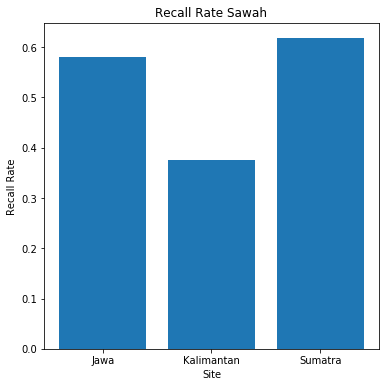

In [26]:
precision_bukan_sawah = TN / (FP + TP)
print("Precision Bukan Sawah Pulau Jawa:",precision_bukan_sawah)

precision_bukan_sawah1 = TN1 / (FP1 + TP1)
print("Precision Bukan Sawah Pulau Kalimantan:",precision_bukan_sawah1)

precision_bukan_sawah2 = TN2 / (FP2 + TP2)
print("Precision Bukan Sawah Pulau Sumatra:",precision_bukan_sawah2)

import matplotlib.pyplot as plt
import decimal

data = {'Jawa': precision_bukan_sawah, 'Kalimantan': precision_bukan_sawah1, 'Sumatra': precision_bukan_sawah2}
names = list(data.keys())
values = list(data.values())

fig, ax = plt.subplots(1, 1, figsize=(6, 6), sharey=True)
ax.bar(names, values)

plt.title('Recall Rate Sawah')
plt.xlabel('Site')
plt.ylabel('Recall Rate')

In [27]:
from sklearn.model_selection import train_test_split

train_x, valid_x, train_y, valid_y = train_test_split(x,Y,test_size=0.0008,stratify = y)

print("Bentuk array dari dataset train (pelatihan) adalah:",train_x.shape,train_y.shape)
print("Bentuk array dari dataset validation adalah:",valid_x.shape,valid_y.shape)
#print("Bentuk array dari dataset test (pengujian) adalah:",x_test.shape,y_test.shape)

Bentuk array dari dataset train (pelatihan) adalah: (29676, 56, 56, 3) (29676,)
Bentuk array dari dataset validation adalah: (24, 56, 56, 3) (24,)


In [28]:
#Mengkomputasi kelas bobotnya
print(np.unique(train_y,return_counts=True))
print(np.unique(valid_y,return_counts=True))

cw = compute_class_weight("balanced",np.unique(train_y),train_y)
print(cw)

(array([0, 1]), array([14838, 14838]))
(array([0, 1]), array([12, 12]))
[1. 1.]


#Pembuatan Model

In [0]:
import tensorflow as tf
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import pandas as pd

In [30]:
IMG_SHAPE = (56, 56, 3)
# Membuat model dasar (base model) dari pre-trained model MobileNet
base_model = tf.keras.applications.vgg16.VGG16(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
58892288/58889256 [==============================] - 5s 0us/step


In [31]:
base_model.trainable = True
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 56, 56, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 56, 56, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 56, 56, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 28, 28, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 28, 28, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 28, 28, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 14, 14, 128)       0     

In [32]:
model1 = tf.keras.Sequential([
    base_model,  
    tf.keras.layers.Conv2D(16,(3,3),name="conv1",input_shape=(56,56,3),activation="relu",padding="same"),   
    #tf.keras.layers.MaxPool2D((2,2),name="pool1"),
    #layers.Dropout(0.05),
    tf.keras.layers.Conv2D(32,(3,3),name="conv2",padding="same"),
    tf.keras.layers.Activation("relu"),
    #tf.keras.layers.MaxPool2D((2,2),name="pool2"),
    #layers.Dropout(0.05),
    tf.keras.layers.Conv2D(32,(3,3),name="conv3",padding="same"),
    tf.keras.layers.Activation("relu"),
    #tf.keras.layers.MaxPool2D((2,2),name="pool3"),
    #layers.Dropout(0.05),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64,activation="relu"),
    #layers.Dropout(0.05),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Activation("sigmoid",name="prediction")
]
)

model1.compile(optimizer="adam",loss="binary_crossentropy",metrics=["acc"])

model1.summary()


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
conv1 (Conv2D)               (None, 1, 1, 16)          73744     
_________________________________________________________________
conv2 (Conv2D)               (None, 1, 1, 32)          4640      
_________________________________________________________________
activation (Activation)      (None, 1, 1, 32)          0         
_________________________________________________________________
conv3 (Conv2D)               (None, 1, 1, 32)          9248      
_________________________________________________________________
activation_1 (Activation)    (None, 1, 1, 32)          0         
____________________________

In [33]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

#Menyimpan model bobot yang terbaik selama training
ckpt = ModelCheckpoint("paddy.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

history = model1.fit(train_x,train_y,batch_size=2000,epochs=20,validation_data=(valid_x,valid_y),class_weight=cw, callbacks = [ckpt])

Train on 29676 samples, validate on 24 samples
Epoch 1/20
28000/29676 [===========================>..] - ETA: 1s - loss: 0.6902 - acc: 0.6097
Epoch 00001: val_loss improved from inf to 0.69156, saving model to paddy.h5
29676/29676 [==============================] - 33s 1ms/sample - loss: 0.6891 - acc: 0.6152 - val_loss: 0.6916 - val_acc: 0.5417
Epoch 2/20
28000/29676 [===========================>..] - ETA: 0s - loss: 0.6932 - acc: 0.5025
Epoch 00002: val_loss improved from 0.69156 to 0.69003, saving model to paddy.h5
29676/29676 [==============================] - 15s 493us/sample - loss: 0.6931 - acc: 0.5208 - val_loss: 0.6900 - val_acc: 0.5000
Epoch 3/20
28000/29676 [===========================>..] - ETA: 0s - loss: 0.7916 - acc: 0.5181
Epoch 00003: val_loss did not improve from 0.69003
29676/29676 [==============================] - 14s 475us/sample - loss: 0.7860 - acc: 0.5172 - val_loss: 0.6933 - val_acc: 0.5000
Epoch 4/20
28000/29676 [===========================>..] - ETA: 0s - los

#Menggambarkan Hasil Pelatihan

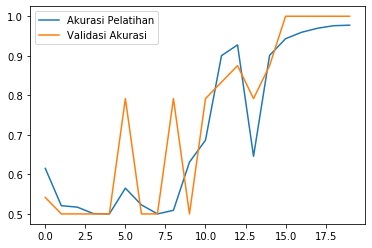

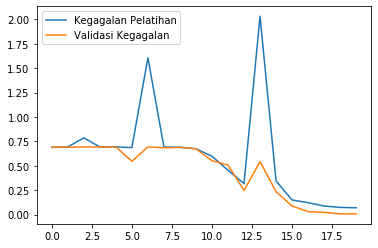

In [34]:
plt.plot(history.history["acc"],label="Akurasi Pelatihan")
plt.plot(history.history["val_acc"],label="Validasi Akurasi")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="Kegagalan Pelatihan")
plt.plot(history.history["val_loss"],label="Validasi Kegagalan")
plt.legend()
plt.show()

In [35]:
import tensorflow as tf
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import pandas as pd

IMAGE_SIZE = 56
BATCH_SIZE = 2000
base_dir = os.path.join('data/paddy/chopped')

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.00029)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

#Memuat dataset pengujian

X_test = []
Y_test = []
labels1 = ['Jawa', 'Kalimantan', 'Sumatra']

for i,label1 in enumerate(labels1):
    folder1 = os.path.join("data/paddy/test",label1)
    files1 = os.listdir(folder1)
    files1 = [x for x in files1 if x.endswith(".jpg")]
    for k,file in enumerate(files1):
        image_path1 = os.path.join(folder1, file)   
        image1 = imread(image_path1)/255.
        image1 = resize(image1,(56,56))
        X_test.append(image1)
        category = os.path.split(folder1)[-1]
        Y_test.append(i)

x_test = np.array(X_test)
y_test = np.array(Y_test)
print(x_test.shape,y_test.shape)

for image_batch, label_batch in train_generator:
  break
print("Bentuk array dari dataset train (pelatihan) adalah:", image_batch.shape,label_batch.shape)
for image_batch, label_batch in val_generator:
  break
print("Bentuk array dari dataset validation (validasi) adalah:", image_batch.shape,label_batch.shape)
print("Bentuk array dari dataset test (pengujian) adalah:", x_test.shape,y_test.shape)

Found 89076 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
(24, 56, 56, 3) (24,)
Bentuk array dari dataset train (pelatihan) adalah: (2000, 56, 56, 3) (2000, 3)
Bentuk array dari dataset validation (validasi) adalah: (24, 56, 56, 3) (24, 3)
Bentuk array dari dataset test (pengujian) adalah: (24, 56, 56, 3) (24,)


# Menyimpan Label

In [36]:
print (train_generator.class_indices)

labels_txt = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels_txt)

{'Jawa': 0, 'Kalimantan': 1, 'Sumatra': 2}


In [37]:
!cat labels.txt

Jawa
Kalimantan
Sumatra

# Membuat Pemodelan dan Pelatihan Model

Sesudah mengimpor dataset, kita akan menggunakan CNN, salah satu arsitektur Deep Learning yang dapat menghandle gambar. Dengan menggunakan Deep CNN, kita dibebaskan dari pendefinisian fitur yang cocok dan hanya memberikan gambar-gambar ke jaringan. CNN akan menentukan fitur yang paling cocok untuk pengklasifikasian.

#Pembuatan Model


In [0]:
IMG_SHAPE = (56, 56, 3)
# Membuat model dasar (base model) dari pre-trained model MobileNet
base_model = tf.keras.applications.vgg16.VGG16(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

## *Feature Extraction*

Menggunakan model pre-trained untuk ekstraksi fitur (feature extraction) : Ketika bekerja dengan dataset kecil, adalah umum untuk mengambil keuntungan dari fitur yang dipelajari oleh model yang dilatih pada dataset yang lebih besar dalam domain yang sama. Ini dilakukan dengan membuat contoh model pre-trained dan menambahkan classifier yang sepenuhnya terhubung di atas. Model pre-trained adalah "beku" dan hanya bobot pengklasifikasi yang diperbarui selama pelatihan. Dalam hal ini, basis konvolusional mengekstraksi semua fitur yang terkait dengan setiap gambar dan Anda baru saja melatih classifier yang menentukan kelas gambar mengingat set fitur yang diekstraksi.

In [39]:
base_model.trainable = True
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 56, 56, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 56, 56, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 56, 56, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 28, 28, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 28, 28, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 28, 28, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 14, 14, 128)       0     

# Mengelompokkan Klasifikasi Tiga Pulau dengan *Deep learning* (*Convolutional Neural Network*)

Sesudah mengimpor dataset, kita akan menggunakan CNN, salah satu arsitektur Deep Learning yang dapat menghandle gambar. Dengan menggunakan Deep CNN, kita dibebaskan dari pendefinisian fitur yang cocok dan hanya memberikan gambar-gambar ke jaringan. CNN akan menentukan fitur yang paling cocok untuk pengklasifikasian.

In [0]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras import layers
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split

## Mempersiapkan Data Masukkan Pengujian

In [0]:
y_test2 = to_categorical(y_test)
x_test3, y_test3 = (x_test, y_test2)

In [42]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Conv2D(16,(3,3),name="conv1",input_shape=(56,56,3),activation="relu",padding="same"),   
    #tf.keras.layers.MaxPool2D((2,2),name="pool1"),
    #layers.Dropout(0.05),
    tf.keras.layers.Conv2D(32,(3,3),name="conv2",padding="same"),
    tf.keras.layers.Activation("relu"),
    #tf.keras.layers.MaxPool2D((2,2),name="pool2"),
    #layers.Dropout(0.05),
    tf.keras.layers.Conv2D(32,(3,3),name="conv3",padding="same"),
    tf.keras.layers.Activation("relu"),
    #tf.keras.layers.MaxPool2D((2,2),name="pool3"),
    #layers.Dropout(0.05),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64,activation="relu"),
    #layers.Dropout(0.05),
    tf.keras.layers.Dense(3),
    tf.keras.layers.Activation("sigmoid",name="prediction")
]
)

model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["acc"])

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
conv1 (Conv2D)               (None, 1, 1, 16)          73744     
_________________________________________________________________
conv2 (Conv2D)               (None, 1, 1, 32)          4640      
_________________________________________________________________
activation_2 (Activation)    (None, 1, 1, 32)          0         
_________________________________________________________________
conv3 (Conv2D)               (None, 1, 1, 32)          9248      
_________________________________________________________________
activation_3 (Activation)    (None, 1, 1, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32)               

In [43]:
#from keras.callbacks import EarlyStopping, ModelCheckpoint 

#Menyimpan model bobot yang terbaik selama training
#ckpt = ModelCheckpoint("paddy.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
history1 = model.fit_generator(train_generator, 
                    epochs=20, 
                    validation_data=val_generator)
#history = model.fit(train_x,train_y,batch_size=200,epochs=100,validation_data=(valid_x,valid_y),class_weight=cw, callbacks = [ckpt])

Epoch 1/20
45/45 [==============================] - 75s 2s/step - loss: 0.6712 - acc: 0.6494 - val_loss: 0.6368 - val_acc: 0.6667
Epoch 2/20
45/45 [==============================] - 42s 935ms/step - loss: 0.6366 - acc: 0.6667 - val_loss: 0.6311 - val_acc: 0.6667
Epoch 3/20
45/45 [==============================] - 42s 933ms/step - loss: 0.5901 - acc: 0.7020 - val_loss: 0.5156 - val_acc: 0.6667
Epoch 4/20
45/45 [==============================] - 42s 933ms/step - loss: 0.4990 - acc: 0.7347 - val_loss: 0.4454 - val_acc: 0.7083
Epoch 5/20
45/45 [==============================] - 42s 933ms/step - loss: 0.4121 - acc: 0.7743 - val_loss: 0.1932 - val_acc: 0.8889
Epoch 6/20
45/45 [==============================] - 42s 932ms/step - loss: 0.3607 - acc: 0.8127 - val_loss: 0.1635 - val_acc: 0.8889
Epoch 7/20
45/45 [==============================] - 42s 934ms/step - loss: 0.3071 - acc: 0.8683 - val_loss: 0.2385 - val_acc: 0.7917
Epoch 8/20
45/45 [==============================] - 42s 933ms/step - los

#Menggambarkan Hasil Pelatihan

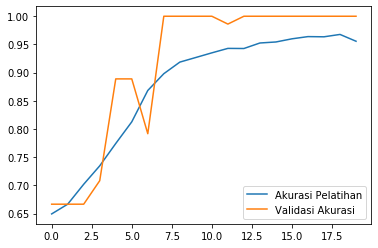

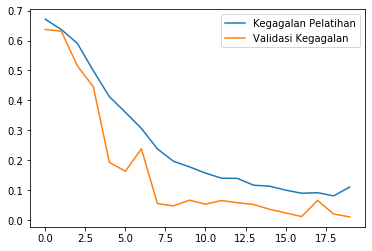

In [44]:
plt.plot(history1.history["acc"],label="Akurasi Pelatihan")
plt.plot(history1.history["val_acc"],label="Validasi Akurasi")
plt.legend()
plt.show()

plt.plot(history1.history["loss"],label="Kegagalan Pelatihan")
plt.plot(history1.history["val_loss"],label="Validasi Kegagalan")
plt.legend()
plt.show()

# Evaluasi dengan model


In [45]:
#Memeriksa matriks model
print(model.metrics_names)
#Evaluasi data training
print(model.evaluate(train_generator))
#Evaluasi validasi data
print(model.evaluate(val_generator))
#Evaluasi test data
#print(model.evaluate(x= x_test3, y = y_test3))

['loss', 'acc']
45/45 [==============================] - 25s 562ms/step - loss: 0.0766 - acc: 0.9695
[0.07662557090322177, 0.969483]
1/1 [==============================] - 0s 29ms/step - loss: 0.0112 - acc: 1.0000
[0.011243395507335663, 1.0]


In [46]:
#Menampilkan matriks yang benar dan matriks hasil prediksi

#Label yang benar
y_true = np.argmax(y_test2,axis=1)

#Label prediksi
Y_pred = model.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)

print(y_true)
print(y_pred)

[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2]
[0 1 0 0 0 0 0 1 2 0 0 0 2 1 1 1 1 1 1 0 0 1 0 1]


Normalized confusion matrix
[[0.75 0.25 0.  ]
 [0.38 0.38 0.25]
 [0.38 0.62 0.  ]]


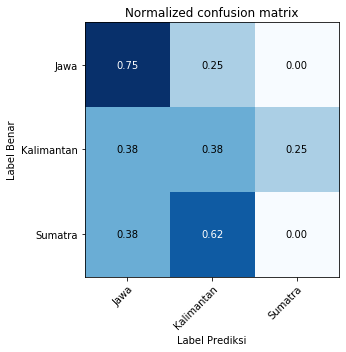

In [47]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Label Benar',
           xlabel='Label Prediksi')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

plot_confusion_matrix(y_true, y_pred, classes=labels1, normalize=True,
                      title='Normalized confusion matrix')

# Evaluasi Gambar Pelatihan dengan Gambar Test data

In [0]:
#Memuat file bobot model keras ".h5" dengan paling sedikit data validasi yang hilang/error
#File ini akan dikonversi ke tensorflow lite
model1.load_weights("paddy.h5")

In [49]:
print(X_train, y_train)
print(X_train.shape, y_train.shape)
print(test_x, test_y)
print(test_x.shape, test_y.shape)
print(X_train1, y_train1)
print(X_train1.shape, y_train1.shape)
print(test_x1, test_y1)
print(test_x1.shape, test_y1.shape)
print(X_train2, y_train2)
print(X_train2.shape, y_train2.shape)
print(test_x2, test_y2)
print(test_x2.shape, test_y2.shape)

[[0.08 0.16 0.14 ... 0.06 0.13 0.12]
 [0.09 0.21 0.15 ... 0.1  0.18 0.13]
 [0.57 0.51 0.52 ... 0.75 0.73 0.73]
 ...
 [0.54 0.47 0.51 ... 0.47 0.4  0.43]
 [0.52 0.51 0.45 ... 0.36 0.42 0.35]
 [0.06 0.14 0.11 ... 0.06 0.14 0.12]] [1 1 0 ... 0 0 1]
(22275, 9408) (22275,)
[[0.51 0.49 0.51 ... 0.13 0.09 0.09]
 [0.35 0.33 0.35 ... 0.2  0.16 0.17]
 [0.73 0.65 0.64 ... 0.4  0.36 0.36]
 ...
 [0.18 0.17 0.24 ... 0.15 0.15 0.12]
 [0.5  0.46 0.46 ... 0.61 0.57 0.58]
 [0.33 0.27 0.3  ... 0.06 0.1  0.12]] [0 0 0 ... 0 0 0]
(7425, 9408) (7425,)
[[0.44 0.4  0.32 ... 0.4  0.42 0.39]
 [0.28 0.33 0.33 ... 0.29 0.33 0.32]
 [0.27 0.34 0.29 ... 0.25 0.32 0.29]
 ...
 [0.33 0.37 0.34 ... 0.29 0.34 0.31]
 [0.22 0.27 0.27 ... 0.24 0.32 0.31]
 [0.52 0.53 0.51 ... 0.63 0.59 0.56]] [0 1 1 ... 1 1 0]
(22275, 9408) (22275,)
[[0.25 0.38 0.31 ... 0.15 0.28 0.21]
 [0.28 0.33 0.34 ... 0.27 0.35 0.33]
 [0.11 0.18 0.18 ... 0.2  0.23 0.23]
 ...
 [0.45 0.45 0.4  ... 0.25 0.29 0.26]
 [0.28 0.34 0.33 ... 0.28 0.31 0.32]
 [0.1

In [50]:
#Memeriksa matriks model
print(model1.metrics_names)
#Evaluasi data training
print(model1.evaluate(x= train_x, y = train_y))
#Evaluasi validasi data
print(model1.evaluate(x= valid_x, y = valid_y))

['loss', 'acc']
29676/29676 [==============================] - 10s 325us/sample - loss: 0.0673 - acc: 0.9783
[0.06726978998442941, 0.97829896]
24/24 [==============================] - 0s 399us/sample - loss: 0.0071 - acc: 1.0000
[0.007056467235088348, 1.0]


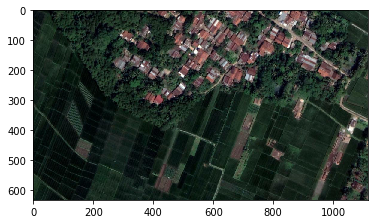

27
1296 27 48


In [51]:
#Membaca Gambar Test Data dan Menampilkannya
img_path = "data/paddy/test/test_image/test_image4.jpg"
img = load_img(img_path)
img = img_to_array(img)/255
plt.imshow(img)
plt.show()

#Membuat subimages dengan patches menggunkan metode sliding windows
patches = []
windows = sw.generate(img, sw.DimOrder.HeightWidthChannel, 56, 0.6)
for i,window in enumerate(windows):
    _img = img[window.indices()]
    patches.append(_img)
patches = np.array(patches)

#Mengecek total gambar dan banyaknya gambar yang terpasang pada height direction, maupun width direction
n_total = len(windows)
_x = 0
for i,window in enumerate(windows):
    if _x != window.x:
        n_x = i
        print(n_x)
        break
    _x = window.x


print(n_total,n_x,n_total//n_x)

In [52]:
print(patches.shape)

(1296, 56, 56, 3)


#Prediksi Gambar Individual

(1296, 1)
[[0.51]
 [0.5 ]
 [0.62]
 ...
 [0.  ]
 [0.  ]
 [0.  ]]


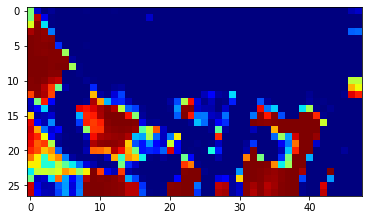

In [54]:
#Memprediksi probalititas keberadaaan lahan sawah padi terhadap gambar yang telah dicacah 
#dan kembali pada gambar original
predictions = model1.predict(patches)
print(predictions.shape)
print(predictions)

paddy = np.reshape(predictions,(n_total//n_x,n_x))
paddy = np.rot90(paddy)
paddy = np.flip(paddy,axis=0)
plt.imshow(paddy,cmap="jet")

In [55]:
print(patches.shape)
print(patches)

(1296, 56, 56, 3)
[[[[0.07 0.11 0.11]
   [0.07 0.1  0.11]
   [0.06 0.09 0.1 ]
   ...
   [0.01 0.04 0.05]
   [0.   0.03 0.04]
   [0.   0.02 0.03]]

  [[0.07 0.1  0.11]
   [0.07 0.1  0.11]
   [0.06 0.09 0.1 ]
   ...
   [0.01 0.04 0.05]
   [0.   0.03 0.04]
   [0.   0.02 0.04]]

  [[0.06 0.09 0.1 ]
   [0.06 0.09 0.1 ]
   [0.06 0.09 0.1 ]
   ...
   [0.01 0.04 0.05]
   [0.01 0.03 0.04]
   [0.   0.02 0.04]]

  ...

  [[0.1  0.13 0.13]
   [0.09 0.13 0.13]
   [0.08 0.12 0.11]
   ...
   [0.09 0.18 0.12]
   [0.11 0.2  0.14]
   [0.13 0.22 0.16]]

  [[0.11 0.15 0.14]
   [0.11 0.15 0.14]
   [0.1  0.14 0.13]
   ...
   [0.09 0.18 0.11]
   [0.1  0.19 0.13]
   [0.11 0.2  0.14]]

  [[0.13 0.17 0.16]
   [0.14 0.17 0.17]
   [0.13 0.16 0.16]
   ...
   [0.07 0.16 0.1 ]
   [0.1  0.19 0.13]
   [0.12 0.21 0.15]]]


 [[[0.02 0.04 0.07]
   [0.01 0.04 0.06]
   [0.02 0.04 0.07]
   ...
   [0.11 0.19 0.13]
   [0.11 0.18 0.12]
   [0.1  0.17 0.11]]

  [[0.   0.01 0.03]
   [0.02 0.05 0.07]
   [0.05 0.09 0.1 ]
   ...
   

**Catatan** :
Bahwa setiap gambar sesuai dengan 1 piksel dari probabilitasnya, dan ukurannya tidak kompatibel dengan gambar input.
Oleh karena itu peneliti akan menghitung faktor rasio dan mengubah ukurannya

In [56]:
#Array pada gambar diperbesar menggunakan interpolasi spline
h_factor = img.shape[0]//paddy.shape[0]
w_factor = img.shape[1]//paddy.shape[1]
print(h_factor)

from scipy.ndimage import zoom
zoomed = zoom(paddy,(h_factor,w_factor))

print(zoomed.shape)

23
(621, 1104)


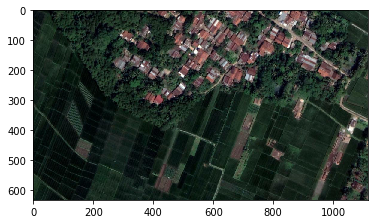

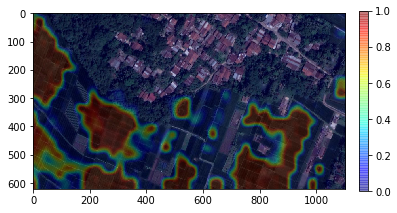

In [57]:
#Menampilkan hasil gambar level tertentu
plt.imshow(img)
plt.show()

plt.imshow(img)
plt.imshow(zoomed,alpha=0.3,vmax=1.0,vmin=0,cmap="jet")

plt.colorbar(fraction=0.027, pad=0.04,alpha=0)
plt.show()

#Menampilkan Luas Lahan Sawah yang berwarna Merah


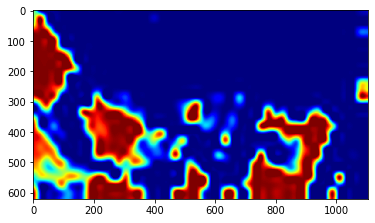

In [58]:
plt.imshow(zoomed,alpha=1,vmax=1.0,vmin=0,cmap="jet")

#Menghitung luas Sawah 


In [59]:
#Menampilkan nilai level zoomed dalam range acak
print("Minimal level zoomed :", np.min(zoomed))
print("Maximal level zoomed :", np.max(zoomed))

Minimal level zoomed : -0.23352283
Maximal level zoomed : 1.2404641


In [60]:
#Menampilkan nilai level zoomed dalam range 0 sampai 1
normalized = (zoomed-np.min(zoomed))/(np.max(zoomed)-np.min(zoomed))
print("Minimal level ternomalisasi:", np.min(normalized))
print("Maximal level ternomalisasi:", np.max(normalized))

Minimal level ternomalisasi: 0.0
Maximal level ternomalisasi: 1.0


In [61]:
#Menghitung luas lahan sawah dalam piksel
#Tingkatan level warna dari 0 sampai 1 yang mencapai bentuk sawah adalah 0.5 (Nilai diantara 0 dan 1)
luaspiksel=(normalized>0.5).sum()
akurasi=((normalized>0.5).sum()*100/(normalized<1).sum())
print("Luas lahan sawah dalam piksel :", (luaspiksel))
print("akurasi dalam piksel :", (akurasi))

Luas lahan sawah dalam piksel : 149234
akurasi dalam piksel : 21.767459228131386


**"Validasi Nilai Piksel ke dalam Meter"**

![image](https://raw.githubusercontent.com/Gio1709/paddy/master/zoomed%20gambar.jpg)

Dapat dilakukan dengan cara :
1.   Menzoom/memperbesar sampel gambar (sampai batas maksimum).
2.   Menghitung jumlah piksel, sebagai contoh pada objek Bus. Diketahui pada umumnya Bus memiliki lebar sebesar 2,5 Meter. [Resolusi Gambar adalah 1116x632 piksel]
3.   Kalkulasi nilai lebar Bus dalam piksel, disini berjumlah 8 piksel. Lalu dilakukan perhitungan sebagai berikut :
    *   Nilai Meter/Piksel(**M/P**) = **M**(meter) / **P**(piksel)
                           = 2,5 meter / 8 piksel
                           = 0,3125 m/p 
                           ~= 0,3 m/p

Maka konversi 1 piksel menjadi meter pada gambar ini sebesar 0,3 

Untuk menghitung luas maka dilakukan dengan 0,3 x 0,3 = 0,09



**Atau dengan pembanding validitas lainnya, yaitu menggunakan software Google Earth**

![image](https://raw.githubusercontent.com/Gio1709/paddy/master/google%20earth.jpg)

Disini diketahui :
*   Jumlah piksel pada garis berwarna kuning adalah 42 piksel
*   Panjang garis berwarna kuning adalah 14,5 meter

Dengan cara yang sama seprti sebelumnya :
 
 dilakukan perhitungan sebagai berikut :

    *   Nilai Meter/Piksel(M/P) = M(meter) / P(piksel)
                           = 14,5 meter / 42 piksel
                           = 0,323 m/p 
                           ~= 0,3 m/p

In [62]:
#Setelah diketahui luas sawah dalam piksel, kemudian menkonversi dalam meter dan hektar
#Untuk menghitung luas maka dilakukan dengan 0,3 x 0,3 = 0,09 
luasmtr = 0.1089*(luaspiksel)
luasha = (luasmtr)/10000
print("Luas lahan sawah dalam meter persegi :", (luasmtr))
print("Luas lahan sawah dalam hektar :", (luasha))

Luas lahan sawah dalam meter persegi : 16251.5826
Luas lahan sawah dalam hektar : 1.62515826
